In [76]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from skimage.transform import resize
from torchvision import transforms
import torch.optim as optim
from torch import LongTensor, FloatTensor
from scipy.stats import skewnorm, genpareto
from torchvision.utils import save_image


data = torch.load('data/real.pt')

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.e1 = nn.Linear(4096,64)
        self.output_layer = nn.Linear(64,4096)
        
    def forward(self,x):
        x = torch.sigmoid(self.e1(x))
        x = self.output_layer(x)
        return x

ae = AutoEncoder().cuda()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

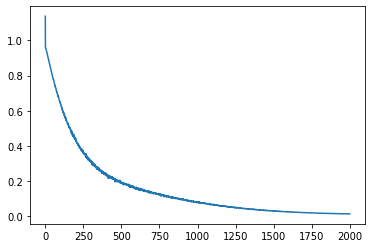

In [77]:
data = data.reshape(data.shape[0], -1)
losses = []
EPOCHS = 400
for epoch in range(EPOCHS):   
    x = torch.autograd.Variable(data[torch.randperm(2557)]).cuda()
    optimizer.zero_grad()
    pred = ae(x)
    loss = loss_func(pred, x)
    losses.append(loss.cpu().data.item())
    loss.backward()
    optimizer.step()
plt.plot(losses)

In [81]:
from scipy import linalg
import warnings

def FID(mu1, mu2, sigma1, sigma2): 
    eps=1e-30
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calcFID(data):
    data = data.reshape(data.shape[0], -1)
    features = torch.sigmoid(ae.e1(data.cuda())).detach().cpu().numpy()
    mean, covar = np.mean(features, 0), np.cov(features, rowvar=False)
    return FID(mean, base_mean, covar, base_covar)


In [82]:
base_features = torch.sigmoid(ae.e1(Variable(data).cuda())).detach().cpu().numpy()
base_mean, base_covar = np.mean(base_features, 0), np.cov(base_features, rowvar=False) 